## 최종 목표는 전기 사용량의 예측

### 가정
- 건물 유형에 따라 전기 사용량에 차이가 있을 것이다.
- 냉방 면적이 넓을수록 전기 사용량이 많아질 것이다.

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
bi = pd.read_csv('building_info.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [49]:
bi.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [50]:
bi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [51]:
bi['건물유형'].unique()

array(['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소',
       '지식산업센터', '할인마트', '호텔및리조트'], dtype=object)

In [52]:
bi = bi.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [53]:
replace_dict = {
    '건물기타': 'Other',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data_Center',
    '백화점및아울렛': 'Department_Store_and_Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Laboratory',
    '지식산업센터': 'Knowledge_Industry_Center',
    '할인마트': 'Discount_Mart',
    '호텔및리조트': 'Hotel_and_Resort'
}

bi['building_type'] = bi['building_type'].replace(replace_dict)
bi.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,Other,110634.00,39570.00,-,-,-
1,2,Other,122233.47,99000.00,-,-,-
2,3,Other,171243.00,113950.00,40,-,-
3,4,Other,74312.98,34419.62,60,-,-
4,5,Other,205884.00,150000.00,-,2557,1000


bi 데이터프레임에서 solar_power_capacity와 ess_capcity, pcs_capacity 열의 경우 결측치를 '-'로 대체한 것으로 보인다.

이에 따라 총 결측치의 수를 확인할 필요가 있다.

In [54]:
print('NA count of solar_power_capacity: {}/{}'.format(len(bi[bi['solar_power_capacity'] == '-']), len(bi)))
print('NA count of ess_capacity: {}/{}'.format(len(bi[bi['ess_capacity'] == '-']), len(bi)))
print('NA count of pcs_capacity: {}/{}'.format(len(bi[bi['pcs_capacity'] == '-']), len(bi)))

NA count of solar_power_capacity: 64/100
NA count of ess_capacity: 95/100
NA count of pcs_capacity: 95/100


확인 결과 과반수가 결측치로, 사용할 수 없는 열로 확인된다.

굳이 사용하려고 한다면 값이 있다면 1, 없다면 0으로 대체하여 범주형 변수로 사용하는 것이 방법이 될 수 있을 것 같다.

In [55]:
train.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [56]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'precipitation',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})

In [11]:
test.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [57]:
test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'precipitation',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity'
})

test에는 존재하지 않는 sunshine, solar_radiation을 drop

추가로 num_date_time 열의 경우 건물 번호와 일시를 합쳐 놓은 열로 보이므로 drop 수행

In [89]:
train.drop(['num_date_time', 'sunshine', 'solar_radiation'], axis=1, inplace=True)
test.drop('num_date_time', axis=1, inplace=True)

KeyError: "['num_date_time', 'sunshine', 'solar_radiation'] not found in axis"

In [13]:
train.head()

,building_num,date_time,temperature,precipitation,windspeed,humidity,power_consumption
0,1,20220601 00,18.6,NaN,0.9,42.0,1085.28
1,1,20220601 01,18.0,NaN,1.1,45.0,1047.36
2,1,20220601 02,17.7,NaN,1.5,45.0,974.88
3,1,20220601 03,16.7,NaN,1.4,48.0,953.76
4,1,20220601 04,18.4,NaN,2.8,43.0,986.40


In [16]:
test.head()

,building_num,date_time,temperature,precipitation,windspeed,humidity
0,1,20220825 00,23.5,0.0,2.2,72
1,1,20220825 01,23.0,0.0,0.9,72
2,1,20220825 02,22.7,0.0,1.5,75
3,1,20220825 03,22.1,0.0,1.3,78
4,1,20220825 04,21.8,0.0,1.0,77


전력 소비량은 계절, 낮과 밤 등 시간의 영향을 받을 것으로 예상되므로 date_time 열을 년, 월, 일, 시간으로 분리한다.

In [59]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
train['hour'] = train['date_time'].dt.hour

In [19]:
train.head()

,building_num,date_time,temperature,precipitation,windspeed,humidity,power_consumption,year,month,day,hour
0,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,1085.28,2022,6,1,0
1,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,1047.36,2022,6,1,1
2,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,974.88,2022,6,1,2
3,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,953.76,2022,6,1,3
4,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,986.40,2022,6,1,4


파일 병합

In [61]:
train = pd.merge(train, bi, on='building_number', how='left')
test = pd.merge(test, bi, on='building_number', how='left')

### 전기 사용량 분포 확인

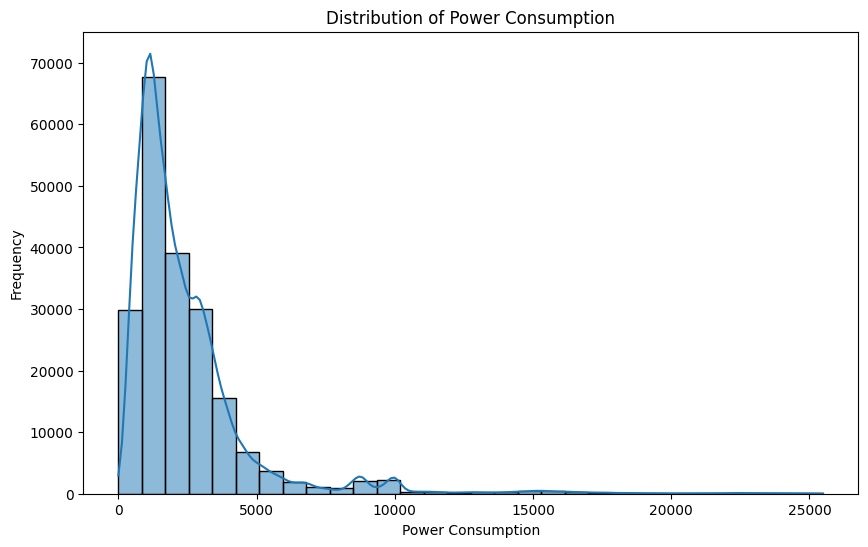

In [75]:
plt.figure(figsize=(10,6))
sns.histplot(train['power_consumption'], bins=30, kde=True)
plt.title('Distribution of Power Consumption')
plt.xlabel('Power Consumption')
plt.ylabel('Frequency')
plt.show()

좌측으로 편향된 것을 확인할 수 있었음

### 시간 별 전력 소비량 분포

In [63]:
train['day_of_year'] = train['date_time'].dt.dayofyear
mean_power_by_day_of_year = train.groupby('day_of_year')['power_consumption'].mean()

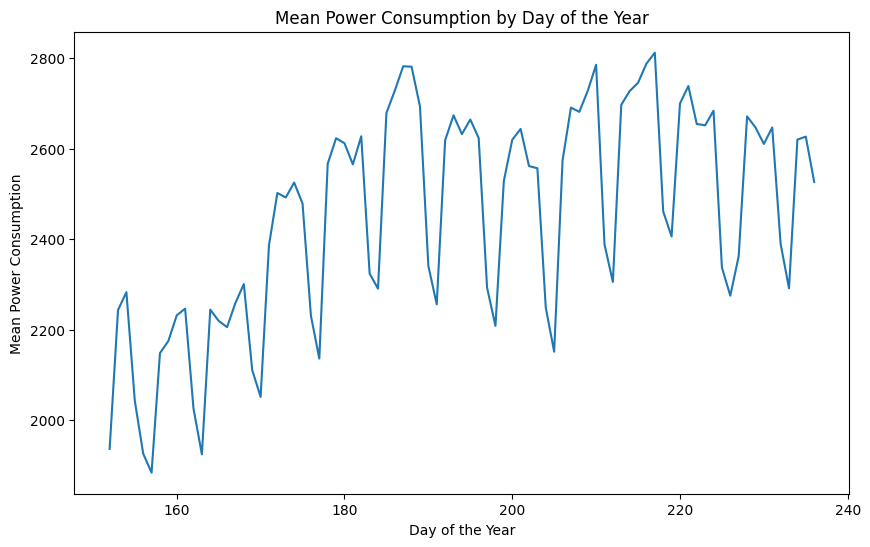

In [77]:
plt.figure(figsize=(10,6))
sns.lineplot(x=mean_power_by_day_of_year.index, y=mean_power_by_day_of_year.values)
plt.title('Mean Power Consumption by Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Power Consumption')
plt.show()

In [65]:
mean_power_by_month = train.groupby('month')['power_consumption'].mean()
mean_power_by_hour = train.groupby('hour')['power_consumption'].mean()

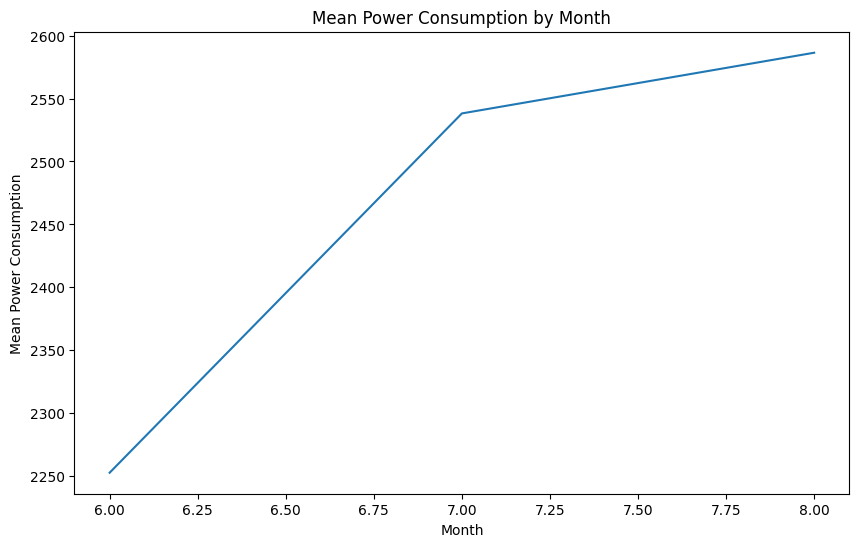

In [78]:
plt.figure(figsize=(10,6))
sns.lineplot(x=mean_power_by_month.index, y=mean_power_by_month.values)
plt.title('Mean Power Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Mean Power Consumption')
plt.show()

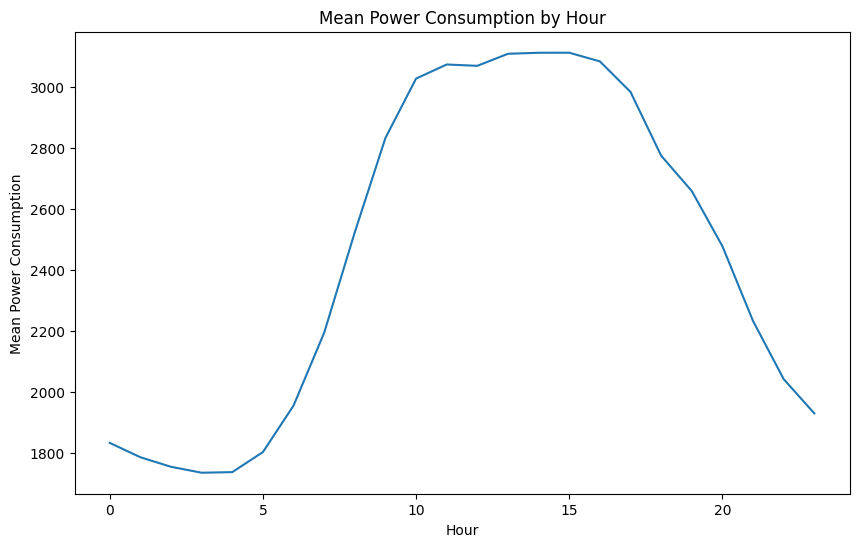

In [79]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_power_by_hour.index, y=mean_power_by_hour.values)
plt.title('Mean Power Consumption by Hour')
plt.xlabel('Hour')
plt.ylabel('Mean Power Consumption')
plt.show()

사람들이 깨어 있고, 일하는 시간대에 주로 전력 사용

In [86]:
train['day_of_week'] = train['date_time'].dt.dayofweek
mean_power_by_day_of_week = train.groupby('day_of_week')['power_consumption'].mean()

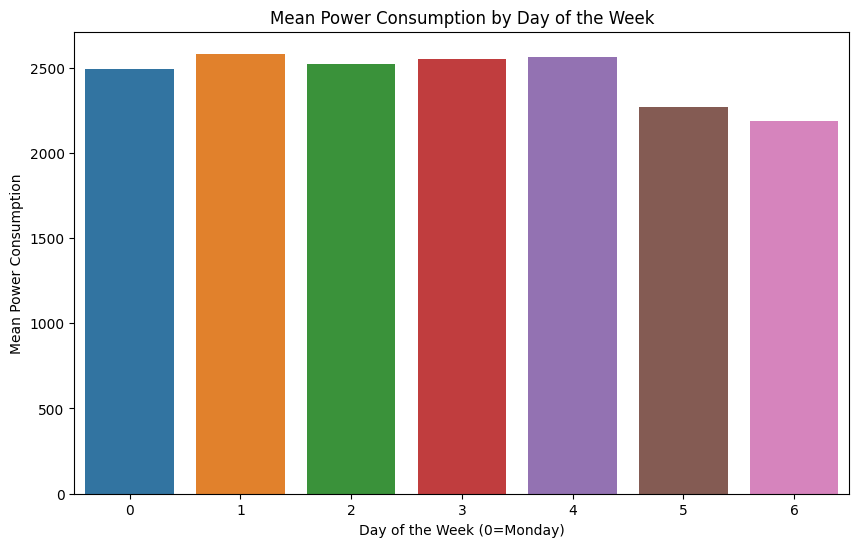

In [80]:
plt.figure(figsize=(10,6))
sns.barplot(x=mean_power_by_day_of_week.index, y=mean_power_by_day_of_week.values)
plt.title('Mean Power Consumption by Day of the Week')
plt.xlabel('Day of the Week (0=Monday)')
plt.ylabel('Mean Power Consumption')
plt.show()

위와 마찬가지로 일하는 요일인 월-금 (0-4)가 전력 사용량이 높음

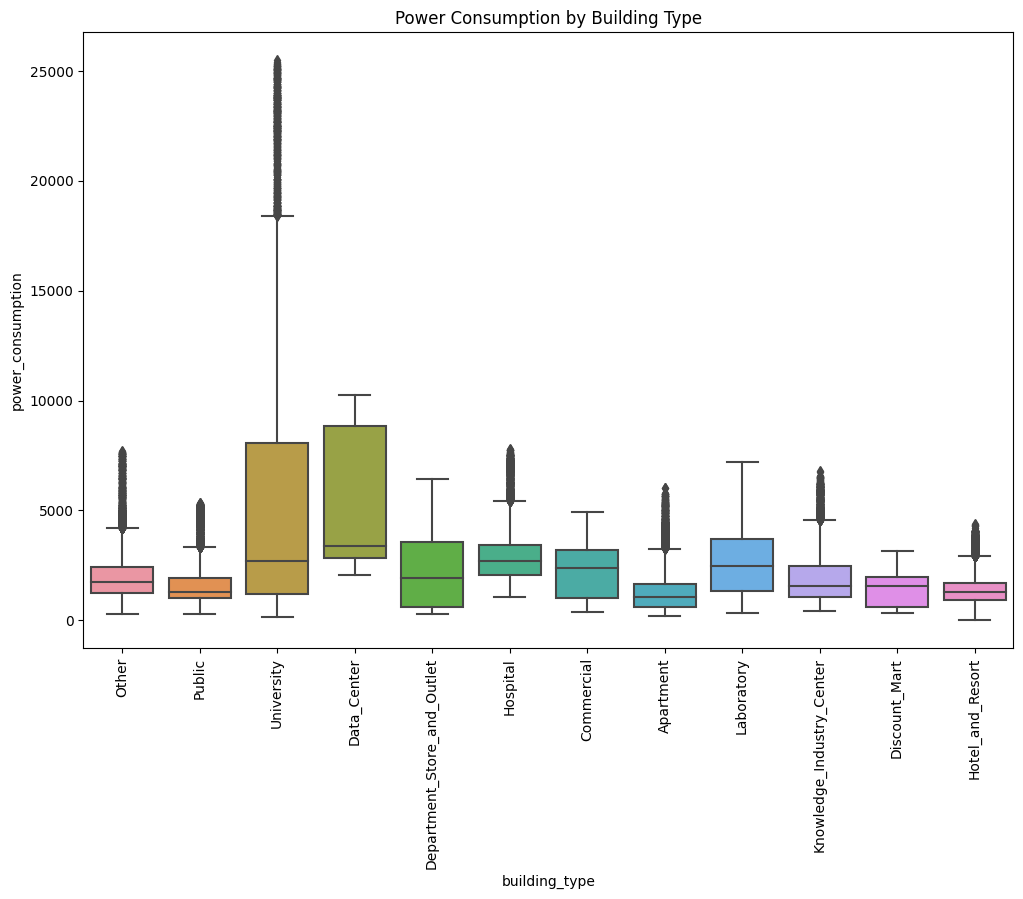

In [81]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='building_type', y='power_consumption', data=train)
plt.title('Power Consumption by Building Type')
plt.xticks(rotation=90)
plt.show()

In [83]:
mean_power_by_hour_building = train.groupby(['hour', 'building_type'])['power_consumption'].mean().reset_index()

pivot = mean_power_by_hour_building.pivot(index='hour', columns='building_type', values='power_consumption')

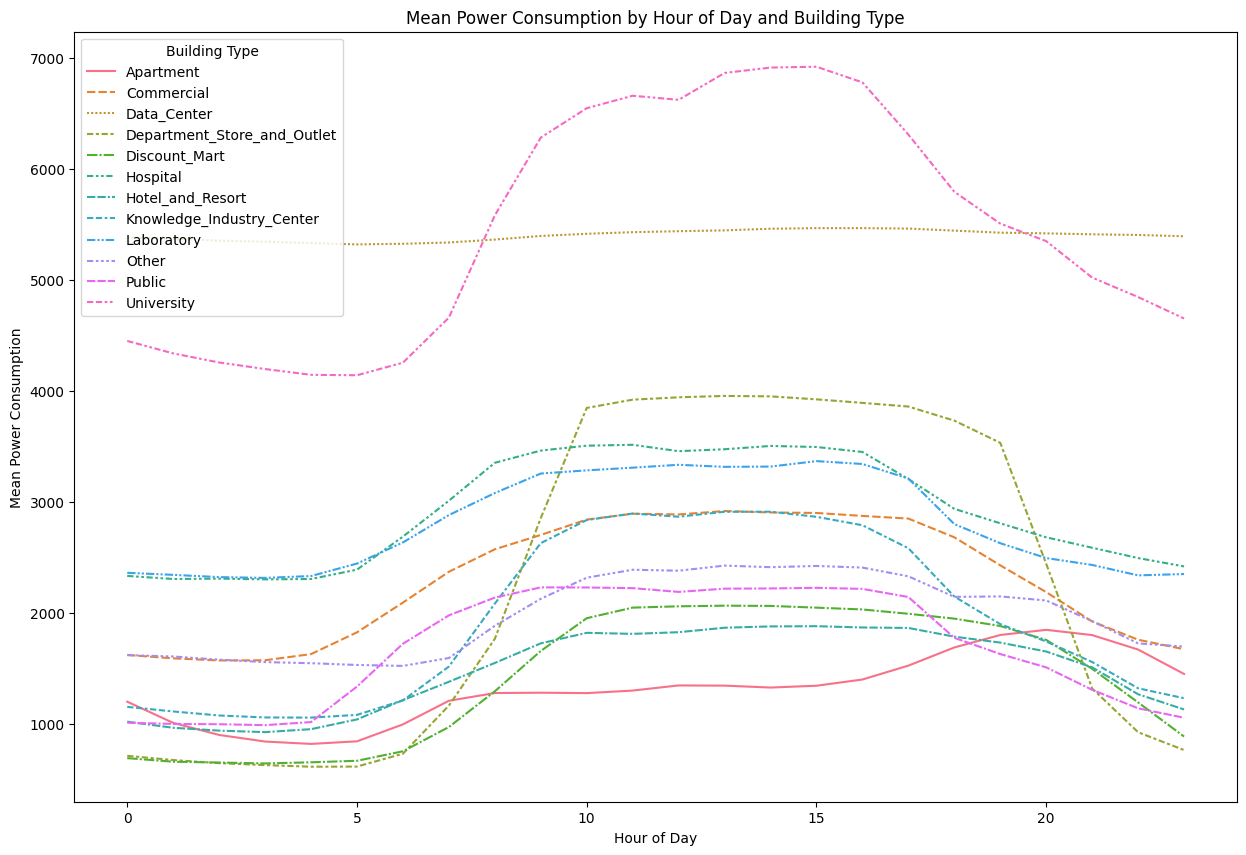

In [84]:
plt.figure(figsize=(15,10))
sns.lineplot(data=pivot)
plt.title('Mean Power Consumption by Hour of Day and Building Type')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

Insight
- 데이터센터의 경우 항상 가동하고 있어야 하여 꾸준히 유지된다.
- 대학의 경우 일하는 시간대에 굉장히 높은 소비량을 보인다.
- 아파트의 경우 저녁 시간대에 잠깐 상승하는데 이는 퇴근 이후 여가활동때문으로 보여짐
- 데이터 센터를 제외하면 대부분 사람이 깨어 있는 시간대에 소비량이 증가하였다가 퇴근 시간 이후에 감소하는 양상을 보임
- 백화점과 대학의 경우 이 증가하는 순간 기울기가 매우 가파르다.

In [91]:
mean_power_by_day_building = train.groupby(['day_of_week', 'building_type'])['power_consumption'].mean().reset_index()

pivot_dow = mean_power_by_day_building.pivot(index='day_of_week', columns='building_type', values='power_consumption')

In [92]:
day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot_dow.index = day

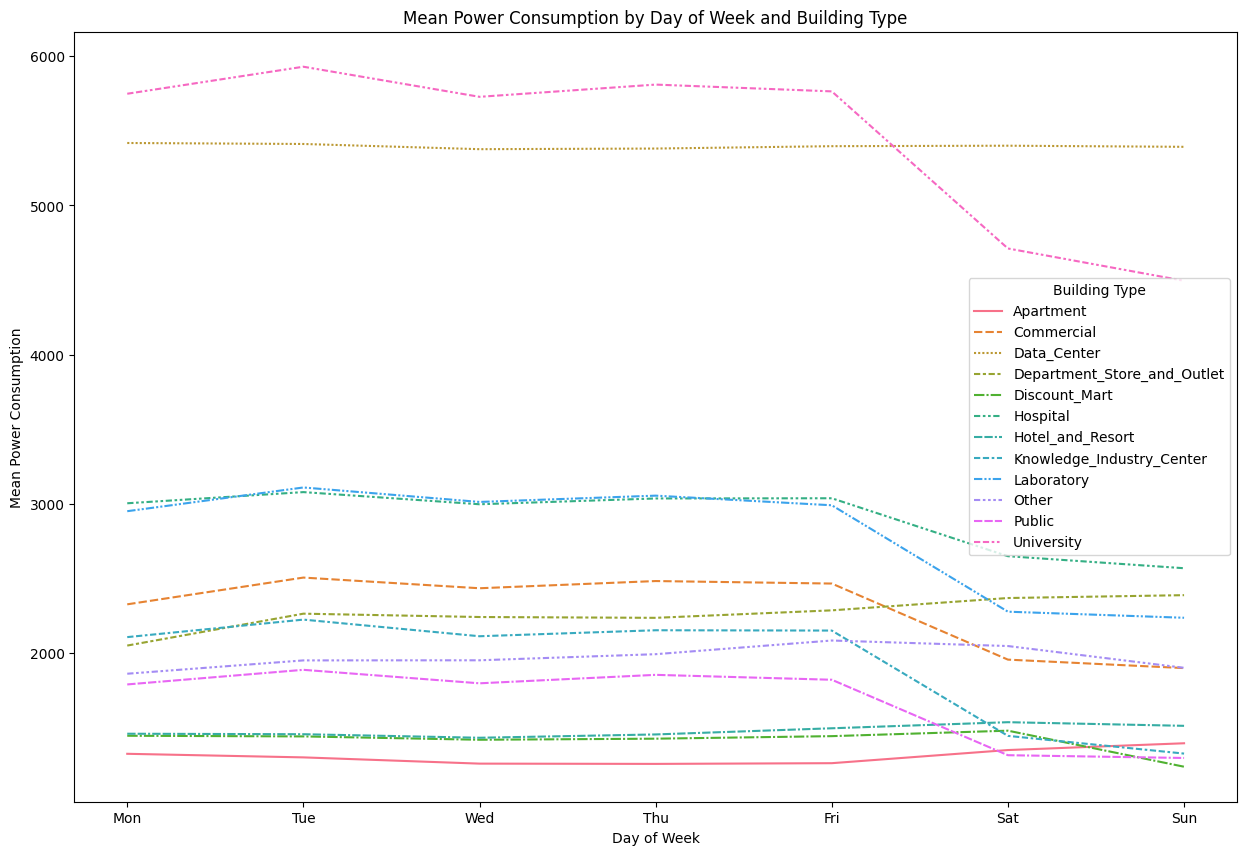

In [93]:
plt.figure(figsize=(15,10))
sns.lineplot(data=pivot_dow)
plt.title('Mean Power Consumption by Day of Week and Building Type')
plt.xlabel('Day of Week')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

Insight
- 데이터센터의 경우 이번에도 꾸준히 유지되는 것을 확인할 수 있었습니다.
- 그 외에도 일반적으로 휴일에도 운영하는 백화점, 병원의 경우도 꾸준히 유지되는 것을 확인할 수 있었습니다.
- 아파트의 경우 주말에 아주 소폭 증가하는 것을 보이지만 거의 평행합니다.
- 휴일에 쉬는 연구실, 상용, 지식 산업 센터, 공공의 경우 주말에 하락세를 보입니다.

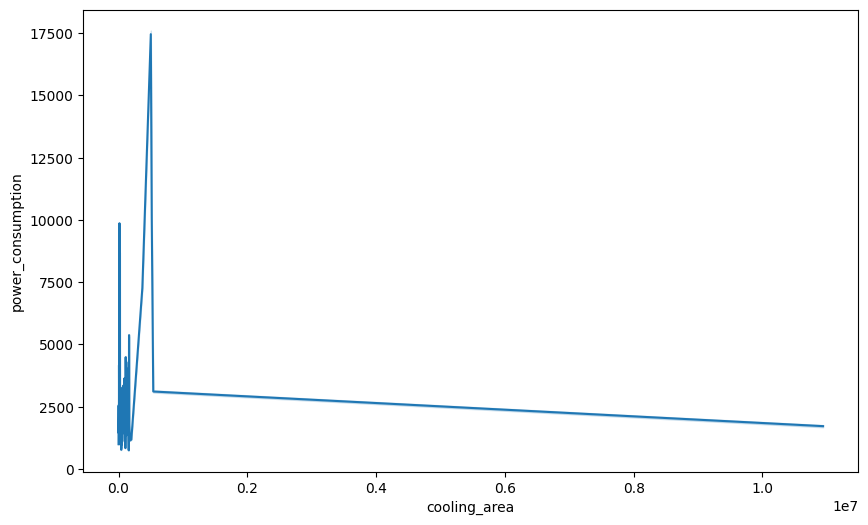

In [95]:
plt.figure(figsize=(10,6))
sns.lineplot(x=train['cooling_area'], y=train['power_consumption'])
plt.show()

In [97]:
bi.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,Other,110634.00,39570.00,-,-,-
1,2,Other,122233.47,99000.00,-,-,-
2,3,Other,171243.00,113950.00,40,-,-
3,4,Other,74312.98,34419.62,60,-,-
4,5,Other,205884.00,150000.00,-,2557,1000


In [100]:
train.replace('-', 0, inplace=True)

In [103]:
train = train.astype({'solar_power_capacity':'float', 'ess_capacity':'float', 'pcs_capacity':'float'})

In [107]:
train = train.astype({'solar_power_capacity':'int', 'ess_capacity':'int', 'pcs_capacity':'int'})

In [104]:
train.loc[train['solar_power_capacity'] > 0, 'solar_power_capacity'] = 1
train.loc[train['ess_capacity'] > 0, 'ess_capacity'] = 1
train.loc[train['pcs_capacity'] > 0, 'pcs_capacity'] = 1

In [112]:
solar = train.groupby(['hour','solar_power_capacity'])['power_consumption'].mean().reset_index()

pivot_solar = solar.pivot(index='hour', columns='solar_power_capacity', values='power_consumption')

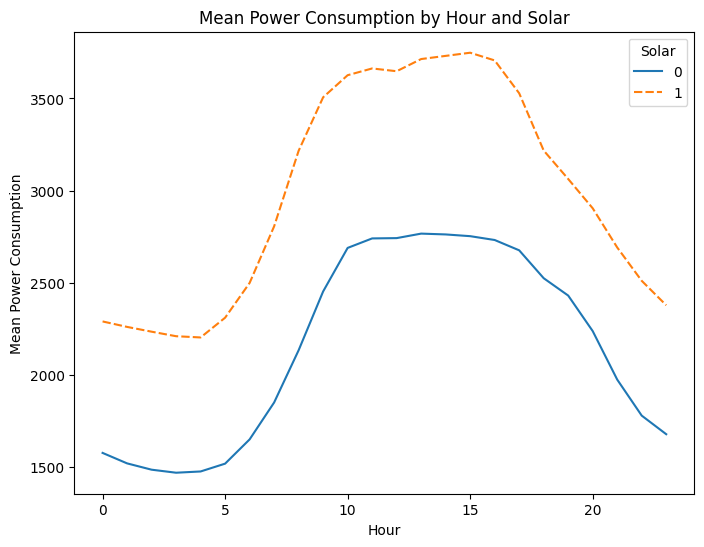

In [114]:
plt.figure(figsize=(8,6))
sns.lineplot(data=pivot_solar)
plt.title('Mean Power Consumption by Hour and Solar')
plt.xlabel('Hour')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Solar')
plt.show()

In [115]:
ess = train.groupby(['hour','ess_capacity'])['power_consumption'].mean().reset_index()

pivot_ess = ess.pivot(index='hour', columns='ess_capacity', values='power_consumption')

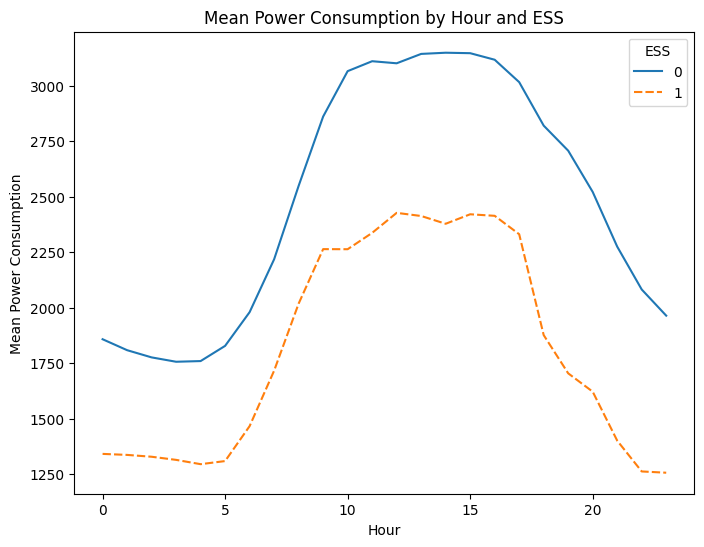

In [116]:
plt.figure(figsize=(8,6))
sns.lineplot(data=pivot_ess)
plt.title('Mean Power Consumption by Hour and ESS')
plt.xlabel('Hour')
plt.ylabel('Mean Power Consumption')
plt.legend(title='ESS')
plt.show()

In [117]:
pcs = train.groupby(['hour','pcs_capacity'])['power_consumption'].mean().reset_index()

pivot_pcs = pcs.pivot(index='hour', columns='pcs_capacity', values='power_consumption')

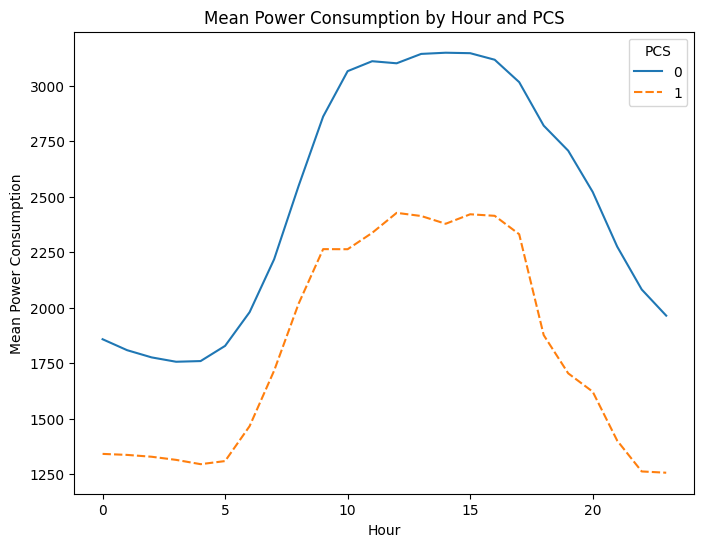

In [118]:
plt.figure(figsize=(8,6))
sns.lineplot(data=pivot_pcs)
plt.title('Mean Power Consumption by Hour and PCS')
plt.xlabel('Hour')
plt.ylabel('Mean Power Consumption')
plt.legend(title='PCS')
plt.show()

결과
- 전력 소모량은 건물 유형의 영향을 받는다.
- 요일의 영향을 받는 유형과 아닌 유형이 존재한다.
- 시간의 영향을 받는 유형과 아닌 유형이 존재한다.
- 냉방 면적이 높다고 반드시 전력 소모량이 높은 것은 아니다.
- solar_capacity, ess_capacity, pcs_capacity의 경우 설치 여부에 따라 값에 차이가 발생한다.

작업 필요
- 평일, 휴일 라벨링
- solar_capacity, ess_capacity, pcs_capacity 설치 여부 라벨링
- 건물 유형 라벨링
- 시간을 구간으로 변경하는 등의 조치 필요 (출근 시간대, 업무 시간대, 퇴근 시간대, 그 외로 4개로 예상)
- 시계열 데이터로의 접근